<H1 align="center">A Weird Approach to count things in image directly using convolutional neural network</H1>
<p align="justify">Object counting is one of the essential purposes of extracting useful data from image. Counting number of people in an image or some other object can be very useful in many applications. Now a standard and probably the best way is to first detect each person and then count the number of bounding boxes or such. Here I am trying to extract this count information from simple generated images direct using convolutional neural network based regressor. I would also be testing its ability to extrapolate.
We would start by generating the dataset. We would be using filled circles as our objects. Now in this kind of images, number of objects can be easily determined using hand crafted filtering techniques like contours and such but here I am testing what CNN can do using what I know about them so far.</p>
First we start by importing some modules.

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
from operator import sub
from tqdm import tqdm
%matplotlib inline

<p align="justify">Now train and test images would be generated. Here I am creating images containing random number of circles having a radius of 10. I am also trying to make sure that the circles are sufficiently far from each other so that they can be individually identified. As for the labels, I simply put the label in the filename. The filenames have a format like <B><random_number>.<no_of_objects>.jpg</B></p>

In [ ]:
def generate_dataset(name,num):
    os.mkdir(name)
    for i in tqdm(range(num)):
        img=np.zeros([400,400,1],np.uint8)
        limit=random.randint(1,100)
        center_coords=[]
        while len(center_coords)<=limit:
            x=random.randint(15,385)
            y=random.randint(15,385)
            found_match=False
            if (x,y) not in center_coords:
                for center_coord in center_coords:
                    diff=tuple(map(sub,(x,y),center_coord))
                    if abs(diff[0])<15 and abs(diff[1])<15:
                        found_match=True
                        break
                if found_match==False:
                    center_coords.append((x,y))
        for i in range(limit):
            cv2.circle(img, center_coords[i], 10, (255,255,255), thickness=-1, lineType=8, shift=0)
        cv2.imwrite(os.path.join(name,str(random.random())+'.'+str(limit)+'.jpg'),img)
generate_dataset('train',10000)
generate_dataset('test',1000)

<p align="Justify">Now we have 10000 train images and 1000 test images. Now we can start working on our Convnet. So lets import things.</p>

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, TimeDistributed
from keras import regularizers
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


<p align="Justify">Here I am just extracting label from each filename and putting image and label in two numpy arrays</p>

In [3]:
def create_dataset_array(name):
    in_arr=[]
    labels=[]
    for file in tqdm(os.listdir(name)):
        filename=os.path.join(name,file)
        file_split=file.split(".")
        label=file_split[len(file_split)-2]
        img=cv2.imread(filename,0)
        img=cv2.resize(img,(100,100))
        img=np.reshape(img,img.shape+(1,))
        in_arr.append(img)
        labels.append(label)
    in_arr=np.array(in_arr)
    return np.array(in_arr),np.array(labels)
train_x,train_y=create_dataset_array('train')

100%|██████████| 10000/10000 [00:11<00:00, 843.17it/s]


<p align="Justify">Now we define our network. How and why such architecture was chosen? well, just by trial and error. For complex images, may be VGG16 or VGG19 or such networks would perform better. For our super simple images, this network is working pretty well.</p>

In [4]:
def network(shape):
    model=Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(150))
    model.add(Activation('relu'))
    model.add(Dense(150))
    model.add(Activation('relu'))
    model.add(Dense(1))
    # COMPILE
    
    model.compile(loss='mse',optimizer='adam',metrics=['mean_absolute_error'])
    return model

model=network(train_x.shape[1:])
print(model.summary())
callback_list=[EarlyStopping(monitor='val_loss',verbose=2,patience=5)]
model.fit(train_x,train_y,epochs=200,batch_size=200,validation_split=0.3,callbacks=callback_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 64)        640       
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 33856)             0         
__________

Epoch 38/200
7000/7000 [==============================] - 10s 1ms/step - loss: 0.5549 - mean_absolute_error: 0.5822 - val_loss: 2.1816 - val_mean_absolute_error: 1.0912
Epoch 39/200
7000/7000 [==============================] - 10s 1ms/step - loss: 0.5620 - mean_absolute_error: 0.5853 - val_loss: 2.1779 - val_mean_absolute_error: 1.0917
Epoch 40/200
7000/7000 [==============================] - 10s 1ms/step - loss: 0.5024 - mean_absolute_error: 0.5537 - val_loss: 2.1605 - val_mean_absolute_error: 1.0880
Epoch 41/200
7000/7000 [==============================] - 10s 1ms/step - loss: 0.4792 - mean_absolute_error: 0.5412 - val_loss: 2.1958 - val_mean_absolute_error: 1.0935
Epoch 42/200
7000/7000 [==============================] - 10s 1ms/step - loss: 0.4864 - mean_absolute_error: 0.5462 - val_loss: 2.1620 - val_mean_absolute_error: 1.0875
Epoch 43/200
7000/7000 [==============================] - 10s 1ms/step - loss: 0.4409 - mean_absolute_error: 0.5244 - val_loss: 2.2160 - val_mean_absolute_

<p align="Justify">Now we test our model.we randomly choose 20 images and out model tries to guess the number of objects.</p>

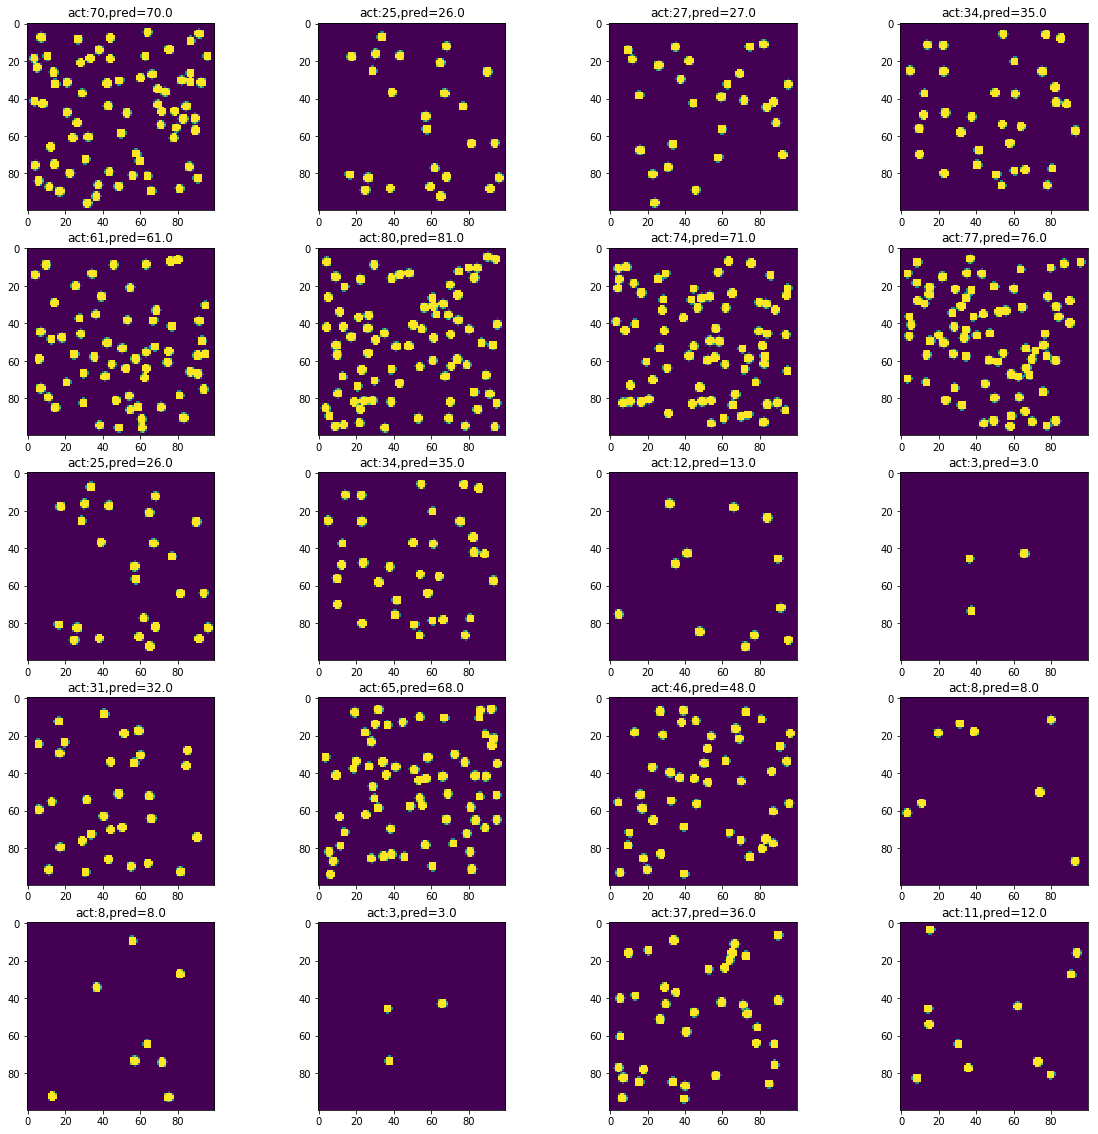

In [5]:
def test_model(folder_name):
    #create a list of 20 random index
    list_index=[random.randint(0,100) for i in range(20)]
    test_img_list=os.listdir(folder_name)
    fig=plt.figure(figsize=(20,20))
    i=1
    for index in list_index:
        img=cv2.imread(os.path.join(folder_name,test_img_list[index]),0)
        img=cv2.resize(img,(100,100))
        file_splt=test_img_list[index]
        file_splt=file_splt.split('.')
        actual_label=file_splt[len(file_splt)-2]
        img_pr=np.reshape(img,(1,)+img.shape+(1,))
        predicted_label=model.predict(img_pr)[0][0]
        ax=fig.add_subplot(5,4,i)
        ax.imshow(img)
        ax.set_title("act:"+str(actual_label)+',pred='+str(round(predicted_label)))
        #print(actual_label,round(predicted_label))
        i+=1
        
    plt.show()
test_model('test')

<p align="Justify">act represents the actual number of circles and pred represents the predicted numbers.Results are not that bad for such a small network that learned the relation between the images and the numbers by itself without any feature engineering.But there is a thing here. All our training and test files contain 1-100 objects. What if we add more? would it be able to guess as good as it did here? Let's find out!</p>

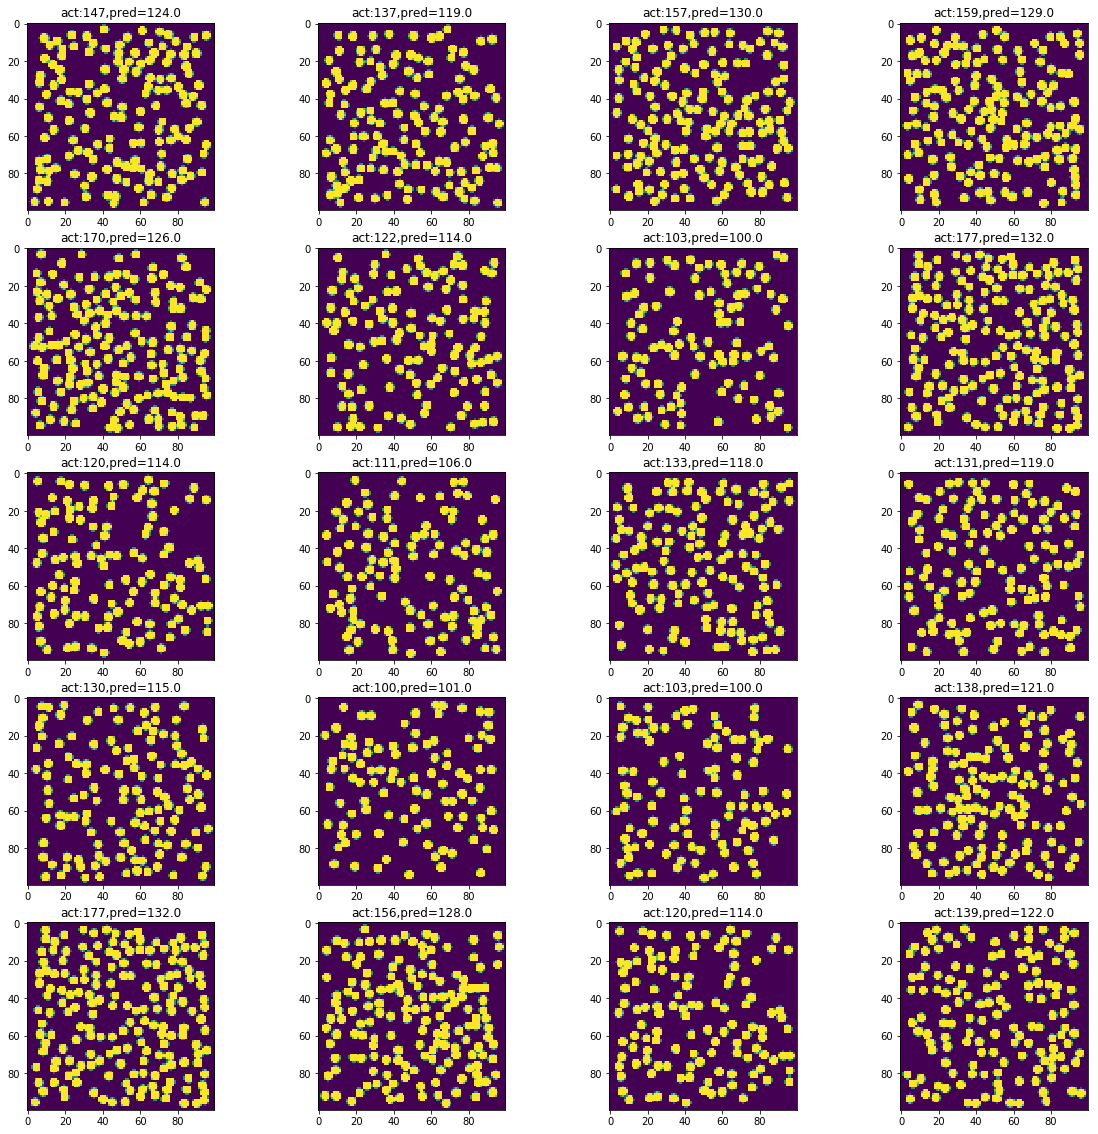

In [6]:
def generate_ext_dataset(name,num):
    if os.path.exists(name):
        return
    os.mkdir(name)
    for i in tqdm(range(num)):
        img=np.zeros([400,400,1],np.uint8)
        limit=random.randint(100,180)
        center_coords=[]
        while len(center_coords)<=limit:
            x=random.randint(15,385)
            y=random.randint(15,385)
            found_match=False
            if (x,y) not in center_coords:
                for center_coord in center_coords:
                    diff=tuple(map(sub,(x,y),center_coord))
                    if abs(diff[0])<15 and abs(diff[1])<15:
                        found_match=True
                        break
                if found_match==False:
                    center_coords.append((x,y))
        for i in range(limit):
            cv2.circle(img, center_coords[i], 10, (255,255,255), thickness=-1, lineType=8, shift=0)
        cv2.imwrite(os.path.join(name,str(random.random())+'.'+str(limit)+'.jpg'),img)
generate_ext_dataset('ext_test',100)
test_model('ext_test')

<p align="justify">Results are aweful here. May be because FeedForward Neural nets arent that good at extrapolating or our images are just to cluttered. It does not that bad close to 100 but beyond 130/140 its aweful.</p>